## NWM Notebook 1: Visualizing Forecasts in Python

<strong><em>Created by <a href="https://www.linkedin.com/in/justin-hunter-0b86871a6/" target="_blank">Justin Hunter</a>, <a href="https://www.linkedin.com/in/danames/" target="_blank">Dr. Dan Ames</a>, and <a href="https://www.linkedin.com/in/easton-perkins-02968a156/" target="_blank">Easton Perkins</a> in collaboration with <a href="https://www.cuahsi.org" target="_blank">CUAHSI</a>.</em></strong><br>
<em><strong>2022. Brigham Young University. Provo, Utah.
<a href="https://hydroinformatics.byu.edu" target="_blank">BYU Hydroinformatics Lab</a>.</em></strong>

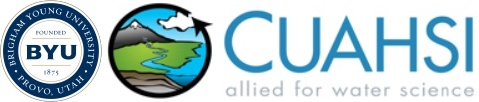

This Jupyter Notebook is a combination of text and Python code. Running the code cells will allow you to explore National Water Model (NWM) forecasts for any river segment covered by the NWM. Run each cell in the order that they appear by hitting the run (play) icon at the top of your screen and be sure to read the comments and notes that are included along the way. It is important to note that if you have opened this notebook in the CUAHSI JupyterHub environment that your available storage is limited. For that reason, this notebook includes code cells that will erase the downloaded forecast files to preserve space. The code deletes files in your Jupyter File Browser containing "nwm" and ".nc".  If you have .nc nwm forecast files that you wish to preserve, move them into a folder or rename them. You could also choose not to run these code cells and opt to manually manage your storage. Be aware that some of the functions in this notebook may not be able to download all of the necessary .nc files to build a time series for a forecast if there isn't enough available storage space. It is usually best to delete any forecast files that you don't need. 

<em><h4>Imports</h4></em>

This next cell imports a few different Python modules or packages that will be used in this notebook. A Python package adds additional functionality to Python. The functions and code in this notebook depend on these packages. If significant changes are made to a package it could affect the functionality of this notebook. The package version numbers originally used for some of the packages are included below along with a brief explanation of what each package will be used for.
* The date type from the datetime module will allow us to call todays date into our code.
* The os module allows us to communicate with the operating system. 
* The requests module lets us make requests to web pages. (2.27.1)
* Xarray lets us work with multidimensional datasets like the NWM forecasts. (0.21.1)
* Matplotlib will help us create some plots. 

In [ ]:
from datetime import date
import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
# Set-up inline plots using matplotlib
%matplotlib inline

<em><h4>Functions</h4></em>

The next code cell defines three functions that are used in the notebook. Short descriptions are provided next to each function as Python comments. Python comments always follow a '#'. Try to understand how the functions work by reading through the code. The first function builds the URL for a given forecast. The next function downloads the given forecast from NOAA. The third function gets a time series of data for a given stream segment and uses the first two functions to get the necessary forecasts.

In [ ]:
# This function builds the url for a specific forecast from the NOAA NWM http file delivery index (https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/)
# The urls are similar to this one: 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210320/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  # The Different forecast types have slightly different urls. The following 'if elif' statements help build valid urls based on the forecast type given to the function.
  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'


# This function downloads the given forecast file from NOAA using its url. You can see that we use os to communicate with the operating system and requests to 'get' what is at that url.
def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  
  return FileName


# This last function gets a time series of data for a stream segment by looping through and grabbing the forecast files at every time interval until the full forecast has been retrieved and added to the series.
# For example, a short range forecast is 18 hours long and has 18 1-hr intervals that need to be retrieved to build the full time series.
# This function only grabs every third forecast for medium range forecasts. That means that the range is 80 for member 1 and 68 for other members. That results in 240-hr (10-day) and 204-hr (8.5 hour) forecasts respectively.
# Long range forecasts have 6-hr intervals which extend out to 30 days (720 hours). That means that the range is 120 (720/6).
def GetSeries(StreamID = 23275226, ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1'):
  TimeSteps = []
  TimeSteps.clear()
  Series = []
  Series.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range' and ForecastMember=='1'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='medium_range' and ForecastMember!='1'):
    for i in range (68):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
      Q = float(data.sel(feature_id=StreamID).streamflow.values)
      Series.append(Q)
    else:
      print('Error getting forecast files.')
    
  return Series

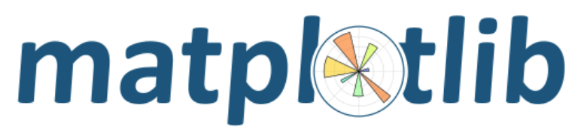

The next few cells use the previously defined functions to get a forecast for a river and display it on a matplotlib plot. Feel free to try changing the variables in the '# Variables' cell. If you choose not to make any changes, you will end up with a plot of today's short range forecast for the Colorado River near Glenwood Springs, Colorado. Depending on the forecast that you've chosen these next few cells could take a while to run.
<br><br>
The goal here is to create a plot similar to the one shown below:
<br>
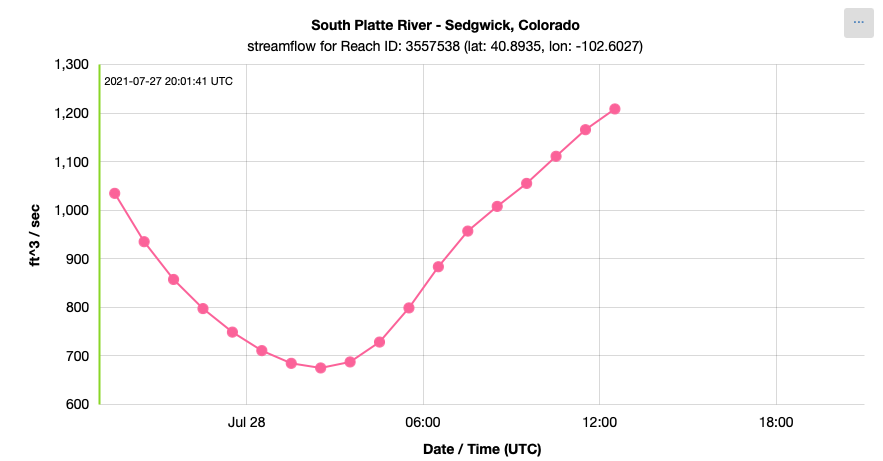
<br>
That plot comes from using NOAA's interactive NWM map (linked below in item #4). We can create similar plots in Python and customize them to our liking.<br>
<br>

Items to note when manipulating variables: 
1. The medium range forecast has 7 members. But Member 1 is 10 days long while members 2-7 are 8.5 days long.
2. The units of the data are cubic meters per second (not cfs).
3. Dates need to be specified in yyyymmdd format and only today or yesterday may be used.
4. If you would like to obtain a different StreamID/ReachID, you can do so by clicking on a river of interest at <a href="https://water.noaa.gov/map" target="_blank">https://water.noaa.gov/map</a>. This interactive map shows all of the reaches in the NWM and allows you to see their attributes and forecasts.
5. All variables should be formatted as strings except for the StreamID which should be an integer.
6. Long range forecasts are 4 member ensembles.

<em><h4>Variables</h4></em>

In [ ]:
# This gets todays date, stores it in yyyymmdd format and assigns it to the variable 'today' which we can use in the next cell
today = date.today()
print(today)
today = str(today)
today = today.replace("-", "")
print(today)

In [ ]:
# Variables
# The unique identifier corresponding to a river segment:
StreamID = 1235819

# Date in YYYYMMDD format. Can only be today or yesterday. Here the variable 'today' is called from the previous cell.
# If you do decide to change this variable be sure to put your date in as a string by placing it inside of quotes like this: 'YYYYMMDD' 
ForecastStartDate = today  

# Timestep forecast was issued, 00 = midnight CST (Central Standard Time), Cannot exceed 24, 
# Cannot be in the future (Example: Today two hours from now)
# For short_range can be 00, 01, 02, 03, etc.
# For medium_range or long_range can be 00, 06, 12, etc.:
ForecastStartTimestep = '00'       

# Options are 'short_range', 'medium_range', and 'long_range':
ForecastType = 'medium_range'       

# Should be 1 for short_range. If using medium_range or 'long_range' then specify the ensemble member 
# (1-4 for long_range or 1-7 for medium_range):
ForecastMember = '1'                

# Now we use the GetSeries function from above, and provide it with the appropriate arguments using the variables that were just created.
Series = GetSeries(StreamID, ForecastStartDate, ForecastStartTimestep, ForecastType, ForecastMember)
print(Series)

# If this cell gives an error, double check that you've passed valid variables and run it again.

<em><h4>Plotting</h4></em>

In [ ]:
# Now lets actually plot the series. 
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title(ForecastType + ' forecast for Stream ID ' + str(StreamID))
ax.grid(True)
# Experiment with changing the color of the series, the size of the plot, or something else and run this cell again.

The next cell erases the forecast files that were downloaded previously. You can see the files on the left hand side of your screen by clicking on the folder icon prior to running the cell. The cell is also written so that it will print out the name of each file that it removes/deletes.

In [ ]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Delete leftover netcdf files 
    if "nwm" in f and f.endswith(".conus.nc"):
        print(f)
        os.remove(f)

Now lets take a look at a few different rivers and their forecasts. Sometimes looking at forecasts for several nearby rivers might provide a better picture of what is going on in that area. Let's take a look at short range forecasts for 3 rivers near Clarksville, TN. The code in the next cell is similar to what we did above. Take a moment to read through it and make sure that you can follow what is happening.

In [ ]:
# Stream/Reach IDs
cumberland_river_id = 11881284
red_river_id = 10169834
little_river_id = 11879984

# Obtaining time series data
cumberland_series = GetSeries(cumberland_river_id, today, '00', 'short_range', '1')
red_series = GetSeries(red_river_id, today, '00', 'short_range', '1')
little_series = GetSeries(little_river_id, today, '00', 'short_range', '1')

# Cumberland River Plot
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(cumberland_series, color='tab:red', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(cumberland_river_id))
ax.grid(True)

# Red River Plot
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(red_series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(red_river_id))
ax.grid(True)

# Little River Plot
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(little_series, color='tab:green', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(little_river_id))
ax.grid(True)

That's pretty cool. However, it might be better to see what these forecasts look like when they are plotted together on one plot. Let's try that next. 

In [ ]:
# Plot all three rivers on the same plot
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(little_series, color='tab:green', label='Streamflow')
ax.plot(cumberland_series, color='tab:blue', label='Streamflow')
ax.plot(red_series, color='tab:red', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('The Cumberland, Red, and Little Rivers' + ' Short Range forecasts')
plt.legend(["Little River", "Cumberland River", "Red River"])
ax.grid(True)

Because the Red River and the Little River have relatively small volumes compared to the much larger Cumberland River, that plot isn't particularly useful. Let's try something else. We can plot all three forecasts on different y axes, but still on the same plot. That will allow us to compare the shapes of the forecasts and maybe learn more about what is going on in the area.

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(9, 9))

# Create two twin axes for the Little River and the Red River
twin1 = ax.twinx()
twin2 = ax.twinx()

# Plot each series and make them each a different color.
ax.plot(cumberland_series, "g-")
twin1.plot(little_series, "b-")
twin2.plot(red_series, "r-")

# Label the axis and offset the labels for the Little River and the Red River
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms) - Cumberland River')
twin1.set_ylabel("Flowrate (cms) - Little River", labelpad=10)
twin2.set_ylabel("Flowrate (cms) - Red River", labelpad=60)

# Set axis labels to match the colors used for each river.
ax.yaxis.label.set_color("blue")
twin1.yaxis.label.set_color("green")
twin2.yaxis.label.set_color("red")

# Set y axes to match the colors used for each river.
ax.tick_params(axis='y', colors="blue")
twin1.tick_params(axis='y', colors="green")
twin2.tick_params(axis='y', colors="red")

# Give the plot a title
ax.set_title('Cumberland, Red, and Little Rivers' + ' Short Range Forecasts')

ax.grid(True)

That plot looks a lot better! Run the next cell to erase any remaining downloaded forecasts!

In [ ]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Delete leftover netcdf files 
    if "nwm" in f and f.endswith(".conus.nc"):
        print(f)
        os.remove(f)

<em><h4>Exercises</h4></em>

The last part of this notebook asks you to try a few things for yourself. Do your best to complete the 4 exercises below or answer the given questions by using what you've learned here. Feel free to add new cells to run any code that you might need to answer a question or complete a task. It may also be a good idea to run the previous cell after each exercise to delete excess files so that your Jupyter notebook's file browser doesn't fill up. 
1. Create a plot of today's medium range forecast for the Mississippi River anywhere along the border between Missouri and Tennessee. HINT: You'll first need to get a reach id, then create a time series, and then plot the series.

2. What is the largest flow expected on the Missouri River through Kansas City in the next ten days? Try to do this two different ways. You should be able to do it by interacting with the NWM map (linked to previously) and by creating and printing a time series for the forecast of appropriate length. Do the two results match? Should they? Why do they or don't they?

3. Try plotting a short range time series for three consecutive reaches of the same river (try to pick a major river). You can choose whether or not to plot them on a single plot or three separate plots. How closely do the three forecasts match? Is there any recognizable trend from one to another? Try thinking about which reach is furthest upstream and which is furthest downstream. How might that affect things?

4. Pick a single reach and plot its short and medium range forecasts together. How closely do the forecasts match over their shared time interval? Knowing what you've learned about the National Water Model, why might they be different? 

Thank you for using this resource! We hope that it has helped you understand the National Water Model a bit better and see how Python can be used to access and visualize its forecasts.